<a target="_blank" href="https://colab.research.google.com/github/pywavelet/pywavelet/blob/main/docs/examples/backends.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Backend comparison

Here we plot the roundtrip of a chirp signal in the frequency domain to the wavelet domain and back to the frequency domain using different backends: NumPy, JAX, and CuPy.

In [ ]:
! pip install pywavelet

In [22]:
from scipy.signal import chirp
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os

from pywavelet.types import TimeSeries, FrequencySeries

PLOT_DIR = f"backend_plots"
os.makedirs(PLOT_DIR, exist_ok=True)


def generate_chirp_time_domain_signal(
        t: np.ndarray, freq_range: List[float]
) -> TimeSeries:
    fs = 1 / (t[1] - t[0])
    nyquist = fs / 2
    fmax = max(freq_range)
    assert (
            fmax < nyquist
    ), f"f_max [{fmax:.2f} Hz] must be less than f_nyquist [{nyquist:2f} Hz]."

    y = chirp(
        t, f0=freq_range[0], f1=freq_range[1], t1=t[-1], method="hyperbolic"
    )
    return TimeSeries(data=y, time=t)


def plot_residuals(ax, residuals):
    ax.hist(residuals, bins=100)
    # add textbox of mean and std
    mean = residuals.mean()
    std = residuals.std()
    textstr = f"$\mu={mean:.1E}$\n$\sigma={std:.1E}$"
    props = dict(boxstyle="round", facecolor="wheat", alpha=0.5)
    ax.text(
        0.05,
        0.95,
        textstr,
        transform=ax.transAxes,
        fontsize=14,
        verticalalignment="top",
        bbox=props,
    )
    ax.set_xlabel("Residuals")
    ax.set_ylabel("Count")
    ax.ticklabel_format(axis="x", style="sci", scilimits=(0, 0))
    return ax


def plot(h_freq, h_reconstructed, h_wavelet, title=None):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    _ = h_freq.plot_periodogram(ax=axes[0], color="black", label="Original")
    _ = h_reconstructed.plot_periodogram(ax=axes[0], ls="--", color="red", label="Reconstructed")
    _ = h_wavelet.plot(ax=axes[1], absolute=True, cmap="Reds")
    _ = plot_residuals(axes[2], h_freq.data - h_reconstructed.data)
    axes[0].legend()
    axes[0].set_title("Orig[black] vs Reconstructed[red]")
    axes[1].set_title("Wavelet Domain")
    axes[2].set_title("Residuals")
    if title is not None:
        fig.suptitle(title)
    plt.tight_layout()
    # remove whitespace in 'title'
    fname = title.replace(" ", "_") if title else "roundtrip"
    fig.savefig(f"{PLOT_DIR}/{fname}.png", dpi=300, bbox_inches="tight")
    plt.close(fig)


# Sizes
dt = 1 / 512
Nt, Nf = 2 ** 6, 2 ** 6
mult = 16
freq_range = (10, 0.2 * (1 / dt))
ND = Nt * Nf
ts = np.arange(0, ND) * dt
h_time = generate_chirp_time_domain_signal(ts, freq_range)
h_freq = h_time.to_frequencyseries()

**Using NumPy**


In [23]:
from pywavelet.transforms.numpy import from_freq_to_wavelet, from_wavelet_to_freq

h_wavelet = from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
h_reconstructed = from_wavelet_to_freq(h_wavelet, dt=dt)
plot(h_freq, h_reconstructed, h_wavelet, title="NumPy Roundtrip")

**Using JAX**

In [26]:
import jax

jax.config.update("jax_enable_x64", True)

from pywavelet.transforms.jax import (
    from_freq_to_wavelet as jax_from_freq_to_wavelet,
)
from pywavelet.transforms.jax import (
    from_wavelet_to_freq as jax_from_wavelet_to_freq,
)

jax_h_wavelet = jax_from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
jax_h_reconstructed = jax_from_wavelet_to_freq(h_wavelet, dt=dt)
plot(
    h_freq, jax_h_reconstructed, jax_h_wavelet, title="JAX Roundtrip"
)

**Using CuPy**

In [38]:
from pywavelet.backend import cuda_is_available

if not cuda_is_available():
    raise RuntimeError("CuPy backend is not available. Please install CuPy with CUDA support.")

from pywavelet.transforms.cupy import (
    from_freq_to_wavelet as cp_from_freq_to_wavelet,
)
from pywavelet.transforms.cupy import (
    from_wavelet_to_freq as cp_from_wavelet_to_freq,
)

cp_h_wavelet = cp_from_freq_to_wavelet(h_freq, Nf=Nf, Nt=Nt)
cp_h_reconstructed = cp_from_wavelet_to_freq(h_wavelet, dt=dt)
plot(h_freq, cp_h_reconstructed, cp_h_wavelet, title="CuPy Roundtrip")

RuntimeError: CuPy backend is not available. Please install CuPy with CUDA support.

| Backend | Roundtrip Plot |
|:---:|:---:|
| NumPy | ![NumPy Roundtrip][numpy] |
| JAX | ![JAX Roundtrip][jax] |
| CuPy | ![CuPy Roundtrip][cupy] |


 
[jax]: backend_plots/JAX_Roundtrip.png
[numpy]: backend_plots/NumPy_Roundtrip.png
[cupy]: backend_plots/CuPy_Roundtrip.png 

## Noise robustness

In [82]:
import numpy as np
from pywavelet.types import TimeSeries, FrequencySeries

np.random.seed(42)  # For reproducibility


def generate_white_noise(N: int = 2048, scale: float = 1.0) -> FrequencySeries:
    """Generate white noise time series."""
    noise = np.random.normal(0, scale, N)
    return TimeSeries(data=noise, time=np.arange(N)).to_frequencyseries()


datasets = [generate_white_noise() for _ in range(100)]


def get_residuals(datasets, forward_transform, inverse_transform, Nf=32):
    mse = np.zeros(len(datasets))
    for i, h_freq in enumerate(datasets):
        h_wavelet = forward_transform(h_freq, Nf=Nf)
        h_reconstructed = inverse_transform(h_wavelet, dt=h_time.dt)
        mse[i] = get_mse(h_freq, h_reconstructed)

    return mse


def get_mse(f1, f2):
    """Calculate Mean Squared Error between two frequency series."""
    return float(np.mean(np.abs(f1.data - f2.data) ** 2))

numpy_mses = get_residuals(
    datasets,
    from_freq_to_wavelet,
    from_wavelet_to_freq
)

jax_mses = get_residuals(
    datasets,
    jax_from_freq_to_wavelet,
    jax_from_wavelet_to_freq
)

if cuda_is_available():
    from pywavelet.transforms.cupy import (
        from_freq_to_wavelet as cp_from_freq_to_wavelet,
    )
    from pywavelet.transforms.cupy import (
        from_wavelet_to_freq as cp_from_wavelet_to_freq,
    )

    cp_mses = get_residuals(
        datasets,
        cp_from_freq_to_wavelet,
        cp_from_wavelet_to_freq
    )
else:
    cp_mses = None

[Text(1, 0, 'NumPy'), Text(2, 0, 'JAX')]

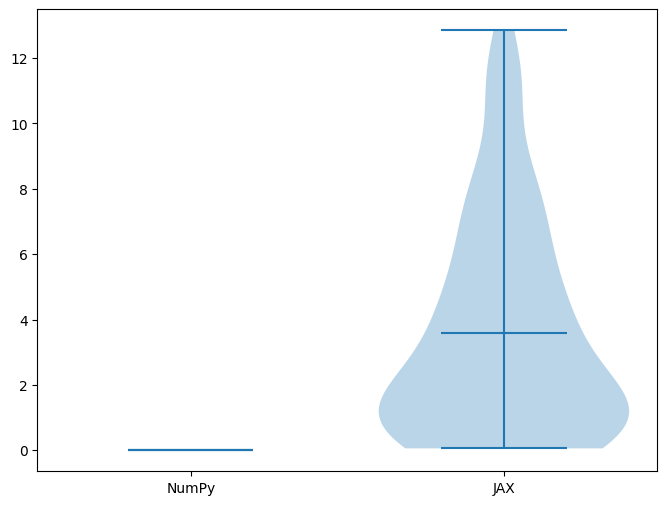

In [83]:
# violin plot of MSEs
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8, 6))
ax.violinplot(
    [numpy_mses, jax_mses] + ([cp_mses] if cp_mses is not None else []),
    showmeans=True,
    showextrema=True,
    widths=0.8
)
ax.set_xticks([1, 2] + ([3] if cp_mses is not None else []))
ax.set_xticklabels(
    ["NumPy", "JAX"] + (["CuPy"] if cp_mses is not None else [])
)


In [84]:
# get max idx of jax_mses
max_idx = int(np.argmax(jax_mses))


Nf = 32
hfreq = datasets[max_idx]
wnm = from_freq_to_wavelet(hfreq, Nf=Nf)
hrecon = from_wavelet_to_freq(wnm, dt=hfreq.dt)
plot(
    hfreq, hrecon, wnm, title="White Noise Roundtrip (NumPy)"
)
get_mse(hfreq, hrecon)  # Print MSE for NumPy roundtrip

1.6673454742985615e-28

In [86]:
wnm_jax = jax_from_freq_to_wavelet(hfreq, Nf=Nf)
hrecon_jax = jax_from_wavelet_to_freq(wnm_jax, dt=hfreq.dt)
plot(
    hfreq, hrecon_jax, wnm_jax, title="White Noise Roundtrip (Jax)"
)
print(get_mse(hfreq, hrecon_jax))  # Print MSE for JAX roundtrip

print("expected MSE for jax roundtrip:", jax_mses[max_idx])

12.848047201614534
expected MSE for jax roundtrip: 12.848047201614534


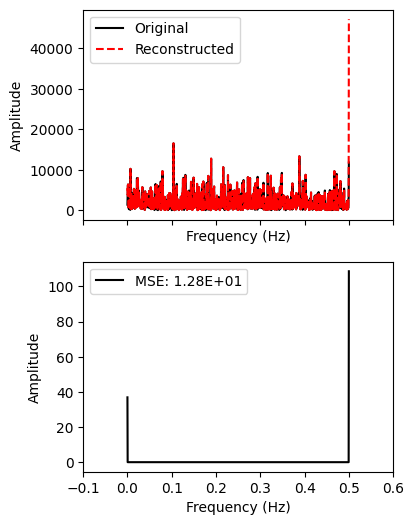

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(4, 6), sharex=True)

hfreq.plot_periodogram(ax=ax[0], color="black", label="Original")
hrecon_jax.plot_periodogram(ax=ax[0], ls="--", color="red", label="Reconstructed")
ax[0].set_xscale("linear")
ax[0].set_xlim(-0.1, 0.6)
ax[0].legend()

resid = np.abs(hfreq.data - hrecon_jax.data)
mse = np.mean(resid ** 2)
ax[1].plot(hfreq.freq, resid, label=f"MSE: {mse:.2E}", color="black")
ax[1].legend()


for a in ax:
    a.set_xlabel("Frequency (Hz)")
    a.set_ylabel("Amplitude")
    a.set_xscale("linear")
    a.set_yscale("linear")


In [71]:
jax_mses

array([ 7.1784282 ,  0.3412282 ,  6.3819535 ,  1.2144013 ,  0.27462733,
        0.69190458,  3.96882098,  1.15552238,  8.02882568,  0.54390046,
        4.83262299,  0.84444492,  2.00600982,  4.17576642,  2.29021299,
        7.46416844,  1.16827308,  1.69226423,  6.89086171, 11.26142015,
        5.04840592,  2.44840229,  0.56005081,  1.68539507,  0.50346409,
        3.09320849,  1.54600895,  5.47859933,  0.71958427,  7.82962478,
        5.364825  ,  5.10632507,  4.00478622,  1.29929241,  9.06782523,
       12.8480472 ,  3.02445406,  3.57816182,  2.71404353,  6.5743191 ,
        0.72477852,  2.02846712,  0.71753285,  0.51137052,  0.70260112,
        0.79245948,  0.70608546,  8.537481  ,  3.36002486,  0.24922118,
        2.01446913,  6.55748283, 10.42802756,  5.46988332,  1.17754993,
        8.85866947,  1.11015473,  1.13743951,  4.99735251,  0.17427547,
        3.44563637,  4.06446234,  1.89372023,  1.29761254,  0.77087475,
        5.84211759,  0.29049541,  3.08546068,  0.91993828, 10.99

In [72]:
numpy_mses

array([1.56234228e-28, 1.57258746e-28, 1.66723035e-28, 1.76215346e-28,
       1.53404667e-28, 1.56837822e-28, 1.65632604e-28, 1.54706616e-28,
       1.65438593e-28, 1.63811294e-28, 1.54475179e-28, 1.54724007e-28,
       1.58555311e-28, 1.59483637e-28, 1.69603676e-28, 1.64195609e-28,
       1.81804776e-28, 1.61780505e-28, 1.47562665e-28, 1.50028632e-28,
       1.79575605e-28, 1.42717436e-28, 1.72361064e-28, 1.74955585e-28,
       1.63744149e-28, 1.56012651e-28, 1.61206537e-28, 1.68867588e-28,
       1.56898742e-28, 1.76253080e-28, 1.56226684e-28, 1.46729010e-28,
       1.41967929e-28, 1.47546484e-28, 1.55150127e-28, 1.66734547e-28,
       1.72207730e-28, 1.67879112e-28, 1.64378918e-28, 1.60704920e-28,
       1.60854996e-28, 1.51156163e-28, 1.69385802e-28, 1.54280096e-28,
       1.51715712e-28, 1.62576714e-28, 1.68348320e-28, 1.56597293e-28,
       1.61650211e-28, 1.50736414e-28, 1.73829863e-28, 1.54307886e-28,
       1.71383423e-28, 1.59127406e-28, 1.52755456e-28, 1.49468120e-28,
      